In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append("../camp_scripts") # change accordingly
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path
from camps.paths import camp_data_path
from june import World
from june.simulator import Simulator
from june.seed import Seed
from june.infection.infection import InfectionSelector
from june.interaction import ContactAveraging
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.world import generate_world_from_hdf5
from june.groups import Cemeteries
from june.policy import Policy, Policies
from june.logger.read_logger import ReadLogger
from june.groups.leisure import leisure
from camp_creation import generate_empty_world, populate_world, distribute_people_to_households # this is loaded from the ../camp_scripts folder

No --data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/JUNE/data
No --configs argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/JUNE/configs
/Users/josephbullock/Documents/campmodelling/JUNE/data
/Users/josephbullock/Documents/campmodelling/JUNE/configs
/Users/josephbullock/Documents/campmodelling/JUNE/camp_data
/Users/josephbullock/Documents/campmodelling/JUNE/configs_camps


In [5]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from june.groups.leisure import HouseholdVisitsDistributor

## Initialize the world

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2020-06-16 12:26:56,082 - june.demography.geography - INFO - There are 65 areas and 4 super_areas in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

In [9]:
hospitals= Hospitals.from_file(
    filename=camp_data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)
hospital_distributor.distribute_medics_from_world(world.people)


2020-06-16 12:26:56,827 - june.groups.hospital - INFO - There are 8 hospitals in the world.


In [10]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)

In [11]:
world.box_mode = False
world.cemeteries = Cemeteries()

## Geography exploration

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-062', 'CXB-219-063', 'CXB-219-061', 'CXB-219-060', 'CXB-219-065']

## Demography exploration

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['f', 'f', 'm', 'm', 'm'], [30, 60, 49, 26, 52])

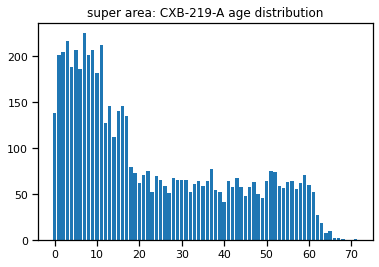

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 48.0%


## Households

### Household size distribution

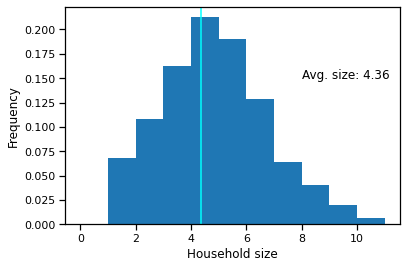

In [20]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

## Activity exploration

### Pumps and latrines 

In [21]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [22]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 3 pumps and latrines in area CXB-219-062


### Distribution centers

In [23]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [24]:
distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### Communal spaces

In [25]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [26]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [27]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [28]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

# Adding the infection

In [29]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [30]:
interaction = ContactAveraging.from_file(config_filename='../configs_camps/defaults/interaction/ContractInteraction.yaml',\
                                         selector=selector)

# Set policies

In [31]:
social_distance = Policy(policy="social_distance",
                         start_time=datetime(2021, 3, 25), 
                         end_time=datetime(2021, 4, 1))
policies = Policies.from_file([social_distance])

# Seed the disease

In [32]:
seed = Seed(world.super_areas,
           selector)

seed.unleash_virus(n_cases=5)

# Run the simulation

In [33]:
CONFIG_PATH = "../configs_camps/config_example.yaml"

leisure_instance = leisure.generate_leisure_for_config(
            world=world
)
leisure_instance.leisure_distributors = [
    PumpLatrineDistributor.from_config(pump_latrines=world.pump_latrines),
    DistributionCenterDistributor.from_config(distribution_centers=world.distribution_centers),
    CommunalDistributor.from_config(communals=world.communals),
    FemaleCommunalDistributor.from_config(female_communals=world.female_communals),
    HouseholdVisitsDistributor.from_config(super_areas=world.super_areas)
]

simulator = Simulator.from_file(
     world, interaction, selector,
    leisure = leisure_instance,
    policies=policies,
    config_filename = CONFIG_PATH
)

In [34]:
simulator.timer.reset()

In [35]:
%%time
simulator.run()

2020-06-16 12:26:58,571 - june.simulator - INFO - Starting group_dynamics for 70 days at day 0
2020-06-16 12:26:58,572 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 70 days
2020-06-16 12:26:59,845 - june.simulator - INFO - Date = 2020-03-07 03:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:00,536 - june.simulator - INFO - Date = 2020-03-07 05:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:01,049 - june.simulator - INFO - Date = 2020-03-07 07:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:01,537 - june.simulator - INFO - Date = 2020-03-07 09:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:01,755 - june.simulator - INFO - Date = 2020-03-07 11:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:02,029 - june.simulator - INFO - Date = 2020-03-08 00:00:00, number of deaths =  0, number of infected = 5
2020-06-16 12:27:02,486 - june.simulator - INFO - Date = 2

2020-06-16 12:27:17,480 - june.simulator - INFO - Date = 2020-03-18 00:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:17,730 - june.simulator - INFO - Date = 2020-03-18 02:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:17,907 - june.simulator - INFO - Date = 2020-03-18 04:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:18,079 - june.simulator - INFO - Date = 2020-03-18 06:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:18,251 - june.simulator - INFO - Date = 2020-03-18 08:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:18,386 - june.simulator - INFO - Date = 2020-03-18 10:00:00, number of deaths =  0, number of infected = 27
2020-06-16 12:27:18,596 - june.simulator - INFO - Date = 2020-03-19 00:00:00, number of deaths =  0, number of infected = 29
2020-06-16 12:27:18,841 - june.simulator - INFO - Date = 2020-03-19 02:00:00, number of deaths =  0, number of infected = 29


2020-06-16 12:27:29,347 - june.simulator - INFO - Date = 2020-03-29 00:00:00, number of deaths =  0, number of infected = 52
2020-06-16 12:27:29,573 - june.simulator - INFO - Date = 2020-03-29 03:00:00, number of deaths =  0, number of infected = 53
2020-06-16 12:27:29,712 - june.simulator - INFO - Date = 2020-03-29 05:00:00, number of deaths =  0, number of infected = 53
2020-06-16 12:27:29,852 - june.simulator - INFO - Date = 2020-03-29 07:00:00, number of deaths =  0, number of infected = 53
2020-06-16 12:27:30,014 - june.simulator - INFO - Date = 2020-03-29 09:00:00, number of deaths =  0, number of infected = 54
2020-06-16 12:27:30,144 - june.simulator - INFO - Date = 2020-03-29 11:00:00, number of deaths =  0, number of infected = 54
2020-06-16 12:27:30,362 - june.simulator - INFO - Date = 2020-03-30 00:00:00, number of deaths =  0, number of infected = 55
2020-06-16 12:27:30,608 - june.simulator - INFO - Date = 2020-03-30 02:00:00, number of deaths =  0, number of infected = 56


2020-06-16 12:27:40,080 - june.simulator - INFO - Date = 2020-04-09 00:00:00, number of deaths =  0, number of infected = 94
2020-06-16 12:27:40,313 - june.simulator - INFO - Date = 2020-04-09 02:00:00, number of deaths =  0, number of infected = 98
2020-06-16 12:27:40,447 - june.simulator - INFO - Date = 2020-04-09 04:00:00, number of deaths =  0, number of infected = 100
2020-06-16 12:27:40,579 - june.simulator - INFO - Date = 2020-04-09 06:00:00, number of deaths =  0, number of infected = 101
2020-06-16 12:27:40,709 - june.simulator - INFO - Date = 2020-04-09 08:00:00, number of deaths =  0, number of infected = 101
2020-06-16 12:27:40,832 - june.simulator - INFO - Date = 2020-04-09 10:00:00, number of deaths =  0, number of infected = 101
2020-06-16 12:27:41,047 - june.simulator - INFO - Date = 2020-04-10 00:00:00, number of deaths =  0, number of infected = 105
2020-06-16 12:27:41,269 - june.simulator - INFO - Date = 2020-04-10 02:00:00, number of deaths =  0, number of infected 

2020-06-16 12:27:50,760 - june.simulator - INFO - Date = 2020-04-20 00:00:00, number of deaths =  0, number of infected = 233
2020-06-16 12:27:50,978 - june.simulator - INFO - Date = 2020-04-20 02:00:00, number of deaths =  0, number of infected = 233
2020-06-16 12:27:51,101 - june.simulator - INFO - Date = 2020-04-20 04:00:00, number of deaths =  0, number of infected = 234
2020-06-16 12:27:51,224 - june.simulator - INFO - Date = 2020-04-20 06:00:00, number of deaths =  0, number of infected = 235
2020-06-16 12:27:51,346 - june.simulator - INFO - Date = 2020-04-20 08:00:00, number of deaths =  0, number of infected = 236
2020-06-16 12:27:51,467 - june.simulator - INFO - Date = 2020-04-20 10:00:00, number of deaths =  0, number of infected = 238
2020-06-16 12:27:51,676 - june.simulator - INFO - Date = 2020-04-21 00:00:00, number of deaths =  0, number of infected = 254
2020-06-16 12:27:51,885 - june.simulator - INFO - Date = 2020-04-21 02:00:00, number of deaths =  0, number of infecte

2020-06-16 12:28:01,505 - june.simulator - INFO - Date = 2020-05-01 00:00:00, number of deaths =  0, number of infected = 480
2020-06-16 12:28:01,719 - june.simulator - INFO - Date = 2020-05-01 02:00:00, number of deaths =  0, number of infected = 482
2020-06-16 12:28:01,841 - june.simulator - INFO - Date = 2020-05-01 04:00:00, number of deaths =  0, number of infected = 485
2020-06-16 12:28:01,973 - june.simulator - INFO - Date = 2020-05-01 06:00:00, number of deaths =  0, number of infected = 488
2020-06-16 12:28:02,102 - june.simulator - INFO - Date = 2020-05-01 08:00:00, number of deaths =  0, number of infected = 490
2020-06-16 12:28:02,220 - june.simulator - INFO - Date = 2020-05-01 10:00:00, number of deaths =  0, number of infected = 493
2020-06-16 12:28:02,428 - june.simulator - INFO - Date = 2020-05-02 00:00:00, number of deaths =  0, number of infected = 514
2020-06-16 12:28:02,654 - june.simulator - INFO - Date = 2020-05-02 03:00:00, number of deaths =  0, number of infecte

2020-06-16 12:28:12,975 - june.simulator - INFO - Date = 2020-05-12 00:00:00, number of deaths =  0, number of infected = 781
2020-06-16 12:28:13,204 - june.simulator - INFO - Date = 2020-05-12 02:00:00, number of deaths =  0, number of infected = 787
2020-06-16 12:28:13,341 - june.simulator - INFO - Date = 2020-05-12 04:00:00, number of deaths =  0, number of infected = 789
2020-06-16 12:28:13,480 - june.simulator - INFO - Date = 2020-05-12 06:00:00, number of deaths =  0, number of infected = 793
2020-06-16 12:28:13,622 - june.simulator - INFO - Date = 2020-05-12 08:00:00, number of deaths =  0, number of infected = 798
2020-06-16 12:28:13,754 - june.simulator - INFO - Date = 2020-05-12 10:00:00, number of deaths =  0, number of infected = 802
2020-06-16 12:28:13,983 - june.simulator - INFO - Date = 2020-05-13 00:00:00, number of deaths =  0, number of infected = 821
2020-06-16 12:28:14,212 - june.simulator - INFO - Date = 2020-05-13 02:00:00, number of deaths =  0, number of infecte

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [36]:
import pandas as pd
read = ReadLogger(load_real=False)

In [37]:
loc_df = read.get_locations_infections()

Text(0.5, 0, 'location')

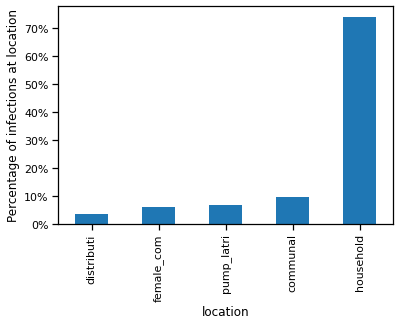

In [38]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

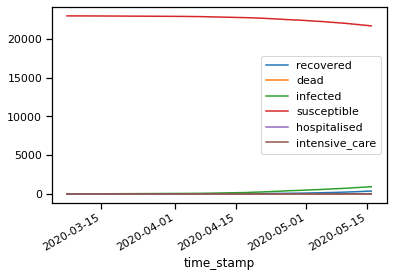

In [40]:
world_df = read.world_summary()
world_df.plot()
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.legend()